In [83]:
#library import
#misc
import pandas as pd
import numpy as np
from datetime import datetime

#time series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from sklearn import metrics

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# keras models
from tensorflow.keras.layers import LSTM, Dense, GRU, Activation, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from keras import backend as K
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint


#holidays
import holidays
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(25, 8)})


#Categories
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

Using TensorFlow backend.


In [2]:
#data import 
df = pd.read_csv("hotel_bookings.csv")
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [3]:
df['arrival_date_year'].unique()

array([2015, 2016, 2017], dtype=int64)

In [4]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [5]:
df['arrival_date_day_of_month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

<p> In this dataset there are data from 01-07-2015 to 29-08-2017 </p>

In [6]:
df['datetime'] = pd.to_datetime(df['arrival_date_year'].map(str) + " " + df['arrival_date_month'].map(str) + " " + df['arrival_date_day_of_month'].map(str))

In [7]:
df['datetime']

0        2015-07-01
1        2015-07-01
2        2015-07-01
3        2015-07-01
4        2015-07-01
            ...    
119385   2017-08-30
119386   2017-08-31
119387   2017-08-31
119388   2017-08-31
119389   2017-08-29
Name: datetime, Length: 119390, dtype: datetime64[ns]

### Cancellation Analysis

<p> We split data into two dataset to count how many cancellation on total there are, then we create a series with total cancellation <br> for every day, number of reservations and percentage </p>

In [8]:
df_canceled = df[df['is_canceled'] == 1]

In [9]:
df_total = pd.DataFrame(df.groupby('datetime').count()['is_canceled'])

In [10]:
df_canceled = pd.DataFrame(df_canceled.groupby('datetime').count()['is_canceled'])

In [11]:
df_total.reset_index(inplace = True)
df_canceled.reset_index(inplace = True)

In [12]:
df_total['datetime'] = pd.to_datetime(df_total['datetime'], utc = True)
df_canceled['datetime'] = pd.to_datetime(df_canceled['datetime'], utc = True)

In [13]:
series = pd.merge(df_canceled, df_total, on = ['datetime'])

In [14]:
series.columns = ['datetime', 'n_canceled', 'n_total']
series

,datetime,n_canceled,n_total
0,2015-07-01 00:00:00+00:00,19,122
1,2015-07-02 00:00:00+00:00,57,93
2,2015-07-03 00:00:00+00:00,19,56
3,2015-07-04 00:00:00+00:00,43,88
4,2015-07-05 00:00:00+00:00,16,53
...,...,...,...
788,2017-08-27 00:00:00+00:00,49,174
789,2017-08-28 00:00:00+00:00,64,211
790,2017-08-29 00:00:00+00:00,44,125
791,2017-08-30 00:00:00+00:00,27,89


In [15]:
series['percentage'] = round(series['n_canceled'] / series['n_total'] * 100, 2)

In [16]:
series = series.set_index('datetime')

### PLot

Text(0.5, 1.0, 'Time Series')

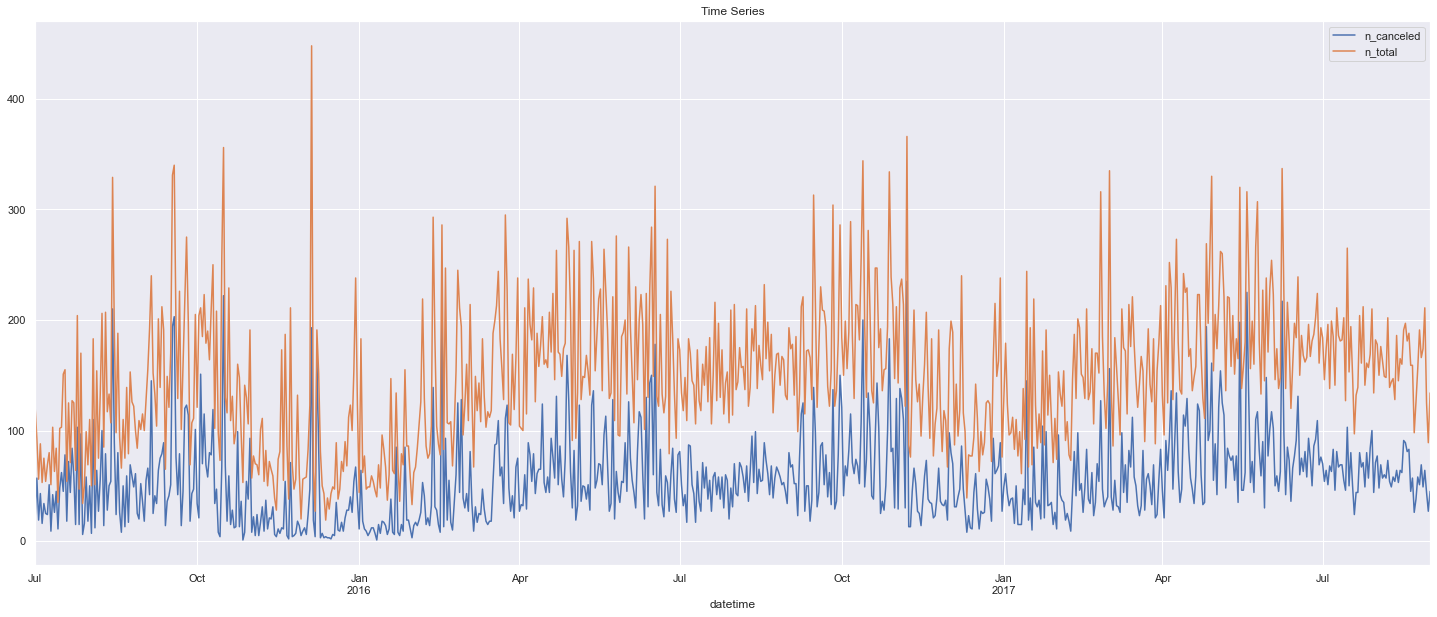

In [17]:
series["n_canceled"].plot(figsize = (25, 10), label = 'n_canceled')
series["n_total"].plot(label = 'n_total')
plt.legend()
plt.title('Time Series')

Text(0.5, 1.0, 'Time Series')

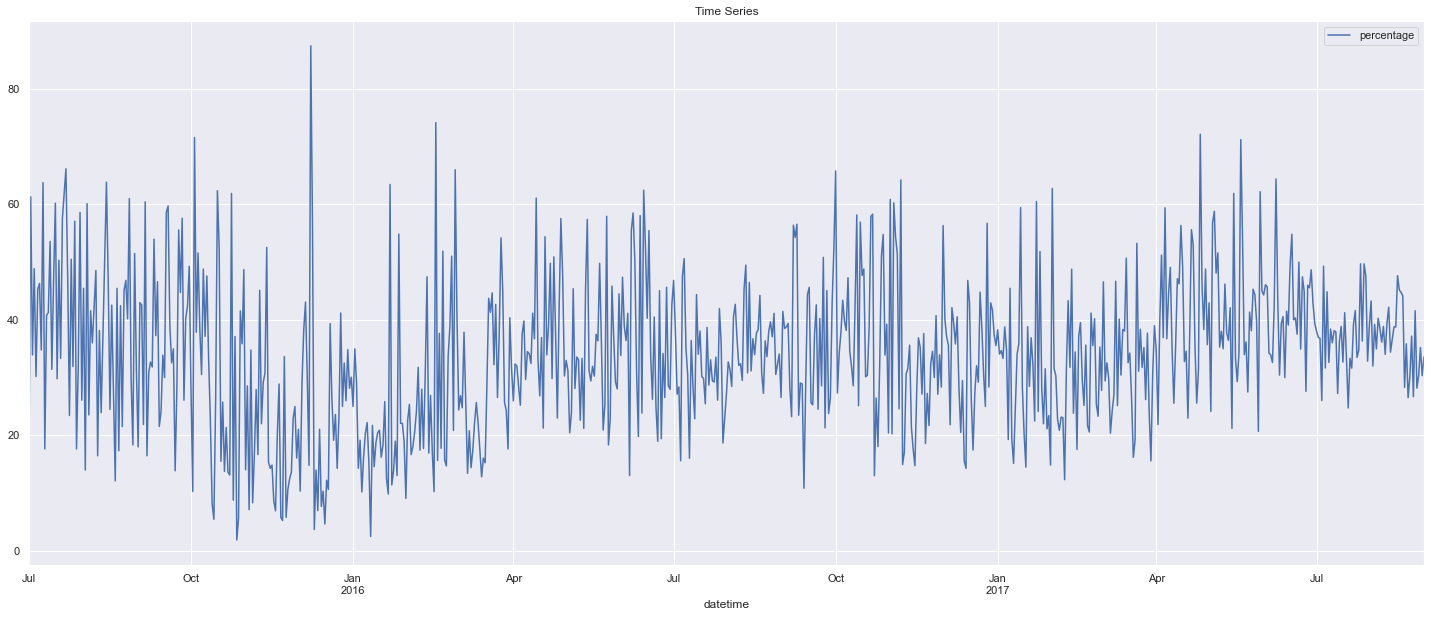

In [18]:
series["percentage"].plot(figsize = (25, 10), label = 'percentage')
plt.legend()
plt.title('Time Series')

### Time Series Creation

In [19]:
# Creazione serie storica
y = series['percentage'].resample('D').sum()

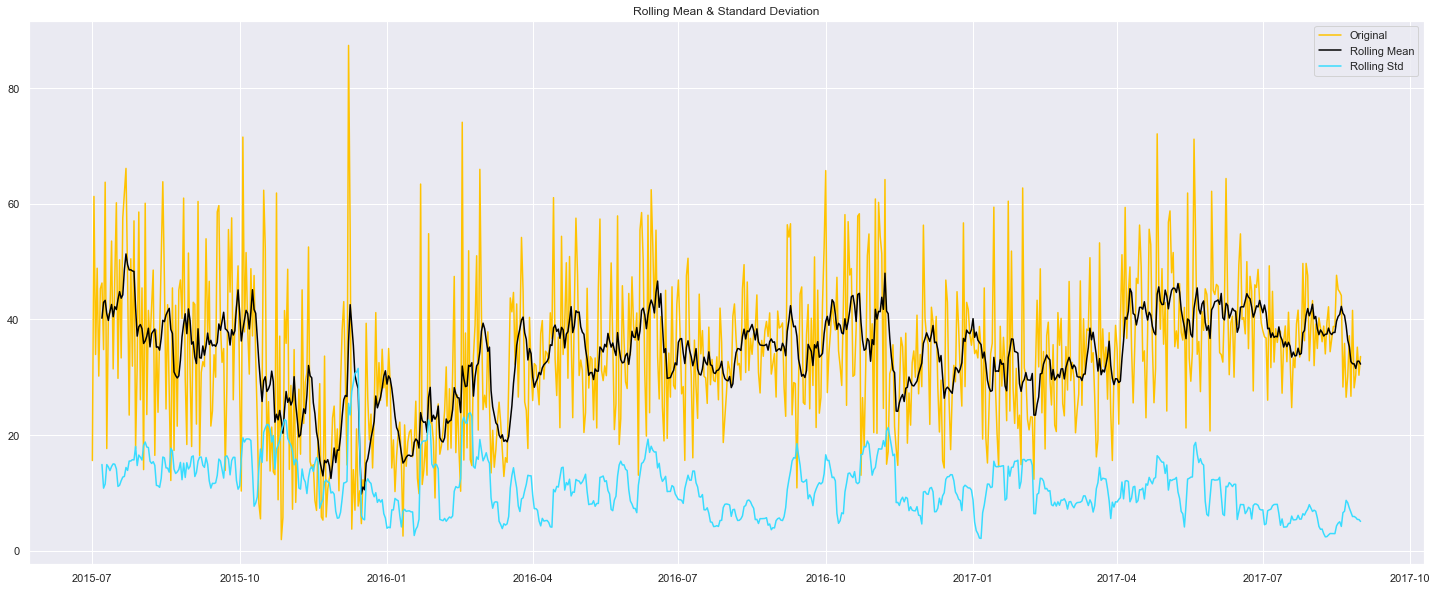

<Results of Dickey-Fuller Test>
Test Statistic                  -3.045284
p-value                          0.030876
#Lags Used                      20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
Critical Value (10%)            -2.568767
dtype: float64


In [20]:
df2 = series['percentage'].resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window = 7).mean()
    rolstd = timeseries.rolling(window = 7).std()
    
    plt.figure(figsize=(25, 10))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color = '#FFC300',label = 'Original')
    mean = plt.plot(rolmean, color = 'black', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = '#38DCFF', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.dropna())

Askewness of normal distribution: 0.294655576384515


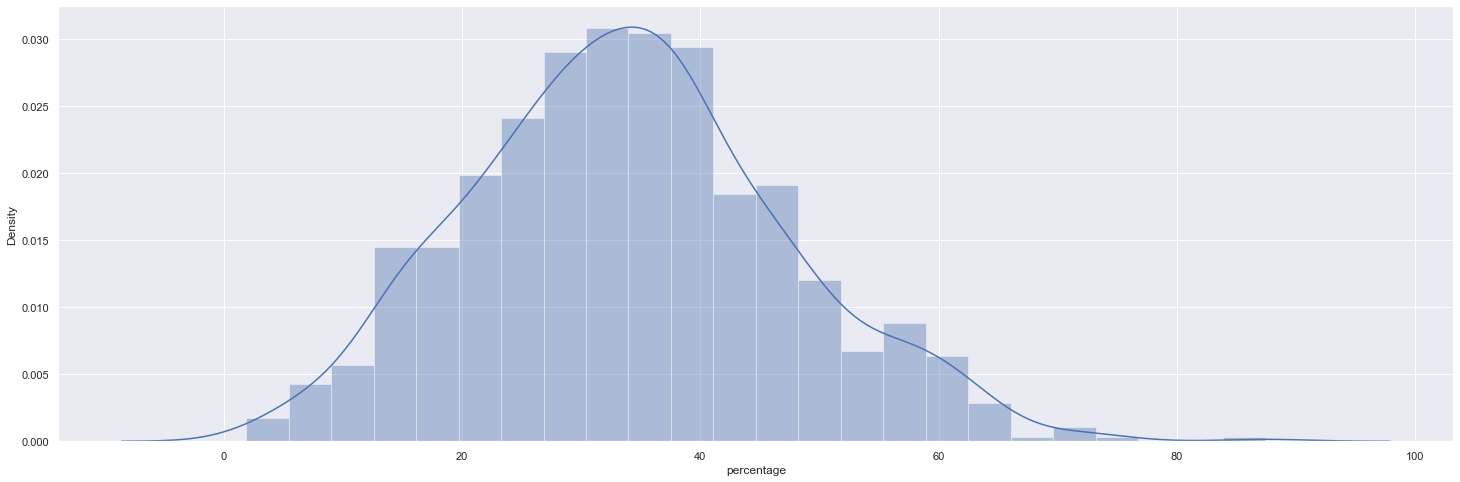

In [21]:
sns.distplot(y); 
print ('Askewness of normal distribution: {}'. format (stats.skew (y)))

<p> In this dataset the percentage seems to be normal with a normal distribution of 0.29 <br>
Seems to be also stationary </p>

array([[<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
        <AxesSubplot:xlabel='datetime'>]], dtype=object)

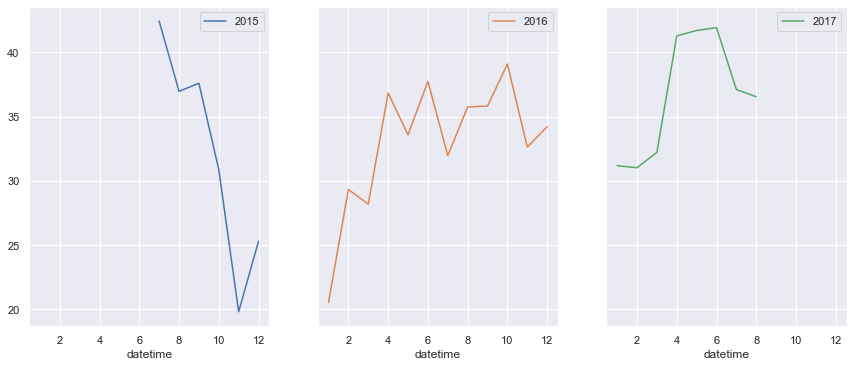

In [22]:
pd.pivot_table(series, values = "percentage", 
               columns = series.index.year, index = series.index.month).plot(subplots = True, figsize=(25, 20), layout=(3, 5), sharey=True)

### Regressor

<p> USA holidays and frequency (7 days and 365 days) were choosen for this type of time series </p>

In [23]:
xreg = pd.DataFrame(columns = ["datetime", "is_holiday"])
xreg_f = pd.DataFrame(columns = ["datetime", "sin7", "cos7", "sin365", "cos365"])

xreg["datetime"] = y.index
xreg_f["datetime"] = y.index
xreg = xreg.set_index(xreg['datetime'])
xreg_f = xreg_f.set_index(xreg_f['datetime'])

In [24]:
xreg["is_weekend"] = y.index.map(lambda x : 1 if x.weekday() > 4 else 0) 

In [25]:
date = []
name = []

for ptr in holidays.UnitedStates(years = [2015, 2016, 2017]).items(): 
    date.append(ptr[0])
    name.append(ptr[1])
h = pd.DataFrame(data = name, index = date)
h.rename(columns = {0 : "holiday"}, inplace = True)
h.head()

,holiday
2016-01-01,New Year's Day
2016-01-18,Martin Luther King Jr. Day
2016-02-15,Washington's Birthday
2016-05-30,Memorial Day
2016-07-04,Independence Day


In [26]:
h.reset_index(inplace = True)
h['index'] = h['index'].apply(lambda x: pd.to_datetime(x, format = "%Y-%m-%d"))
xreg["is_holiday"] = y.index.map(lambda x : 1 if x in h.index else 0) 

In [27]:
xreg_f['sin7'] = np.sin(2 * np.pi * xreg_f.index.dayofyear / 7)
xreg_f['cos7'] = np.cos(2 * np.pi * xreg_f.index.dayofyear / 7)
xreg_f['sin365'] = np.sin(2 * np.pi * xreg_f.index.dayofyear / 365.25)
xreg_f['cos365'] = np.cos(2 * np.pi * xreg_f.index.dayofyear / 365.25)

xreg = xreg[["is_weekend", "is_holiday"]]
xreg.head()

,is_weekend,is_holiday
datetime,,
2015-07-01 00:00:00+00:00,0,0
2015-07-02 00:00:00+00:00,0,0
2015-07-03 00:00:00+00:00,0,0
2015-07-04 00:00:00+00:00,1,0
2015-07-05 00:00:00+00:00,1,0


In [28]:
xreg_f = xreg_f[["sin7", "cos7", "sin365", "cos365"]]
xreg_f.head()

,sin7,cos7,sin365,cos365
datetime,,,,
2015-07-01 00:00:00+00:00,-2.057902e-14,1.000000,0.010751,-0.999942
2015-07-02 00:00:00+00:00,7.818315e-01,0.623490,-0.006451,-0.999979
2015-07-03 00:00:00+00:00,9.749279e-01,-0.222521,-0.023651,-0.999720
2015-07-04 00:00:00+00:00,4.338837e-01,-0.900969,-0.040844,-0.999166
2015-07-05 00:00:00+00:00,-4.338837e-01,-0.900969,-0.058026,-0.998315


In [29]:
xreg_train = xreg.join(xreg_f)
xreg_train.head()

,is_weekend,is_holiday,sin7,cos7,sin365,cos365
datetime,,,,,,
2015-07-01 00:00:00+00:00,0,0,-2.057902e-14,1.000000,0.010751,-0.999942
2015-07-02 00:00:00+00:00,0,0,7.818315e-01,0.623490,-0.006451,-0.999979
2015-07-03 00:00:00+00:00,0,0,9.749279e-01,-0.222521,-0.023651,-0.999720
2015-07-04 00:00:00+00:00,1,0,4.338837e-01,-0.900969,-0.040844,-0.999166
2015-07-05 00:00:00+00:00,1,0,-4.338837e-01,-0.900969,-0.058026,-0.998315


<p> Test Regressor </p>

In [30]:
xreg_p = pd.DataFrame(columns = ["datetime", "is_holiday", "is_weekend"])
xreg_p['datetime'] = pd.date_range('2017-09-01', periods = 30, freq = 'D')
xreg_p.set_index('datetime', inplace = True)
xreg_p['is_weekend'] = xreg_p.index.map(lambda x : 1 if x.weekday() > 4 else 0)
xreg_p["is_holiday"] = xreg_p.index.map(lambda x : 1 if x in h.index else 0) 
xreg_p_f = pd.DataFrame(columns=["datetime", "sin7", "cos7", "sin365", "cos365"])
xreg_p_f['datetime'] = pd.date_range('2017-09-01', periods = 30, freq='D')
xreg_p_f.set_index('datetime', inplace = True)
xreg_p_f['sin7'] = np.sin(2 * np.pi * xreg_p_f.index.dayofyear / 7)
xreg_p_f['cos7'] = np.cos(2 * np.pi * xreg_p_f.index.dayofyear / 7)
xreg_p_f['sin365'] = np.sin(2 * np.pi * xreg_p_f.index.dayofyear / 365.25)
xreg_p_f['cos365'] = np.cos(2 * np.pi * xreg_p_f.index.dayofyear / 365.25)

In [31]:
xreg_test = xreg_p.join(xreg_p_f)
xreg_test.head()

,is_holiday,is_weekend,sin7,cos7,sin365,cos365
datetime,,,,,,
2017-09-01,0,0,-7.818315e-01,0.623490,-0.870294,-0.492533
2017-09-02,0,1,-1.567795e-14,1.000000,-0.878637,-0.477489
2017-09-03,0,1,7.818315e-01,0.623490,-0.886721,-0.462305
2017-09-04,0,0,9.749279e-01,-0.222521,-0.894542,-0.446983
2017-09-05,0,0,4.338837e-01,-0.900969,-0.902099,-0.431530


### Functions

In [32]:
def make_prediction_test(mod, y_true, start, end, xreg):
    y_pred = mod.predict(start = start, end = end, exog = xreg, typ = 'linear', dynamic = False)
    mae = metrics.mean_absolute_error(y_pred = y_pred[1:], y_true = y_true[1:])
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Mean absolute error TEST: " + str(mae))
    print("Mean absolute percentage error TEST: " + str(mape))
    return mae


def make_prediction_train(mod, y_true, start, end, xreg):
    y_pred = mod.predict(start = start, end = end, exog = xreg, typ = 'linear', dynamic = False)
    mae = metrics.mean_absolute_error(y_pred = y_pred[1:], y_true = y_true[1:])
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Mean absolute error TRAIN: " + str(mae))
    print("Mean absolute percentage error TRAIN: " + str(mape))
    return mae


def make_prediction_plot(mod, y_true, start, end, xreg, y_true2, start2, end2, xreg2):
    y_pred = mod.predict(start = start, end = end, exog = xreg, typ = 'linear', dynamic = False)
    y_pred2 = mod.predict(start = start2, end = end2, exog = xreg2, typ = 'linear', dynamic = False)
    plt.rcParams.update({'figure.figsize':(20,15)})
    fig1, axes1 = plt.subplots(2, 1, sharex=True)
    axes1[0].set_title("Prevision on TRAIN")
    axes1[0].plot(y_pred2, color = "#33AAFF", label = "Predected")
    axes1[0].plot(y_true2, color = "#FFC300", label = "Original")
    plt.legend()
    axes1[1].set_title("Prevision on TEST")
    axes1[1].plot(y_pred, color = "#33AAFF", label = "Predected")
    axes1[1].plot(y_true, color = "#FFC300", label = "Original")
    plt.legend()
    return y_pred

In [33]:
def make_arima(data, p, d, q, P, D, Q, period, xreg):
    start = datetime.now()
    mod = sm.tsa.statespace.SARIMAX(data,
                      order=(p, d, q),
                      seasonal_order = (P, D, Q, period),
                      exog = xreg
          )
    mod = mod.fit(disp = 0)
    print(mod.summary())
    stop = datetime.now()
    print("execution time :" + str(stop - start))
    return mod

### Split

In [34]:
train = y[y.index <= ('2017-04-01')]
test = y[y.index > ('2017-04-01')]
print("Train size: " + str(round((len(train) / len(y) * 100), 2)) + "%")
print("Test size: " + str(round((len(test) / len(y) * 100), 2)) + "%")

Train size: 80.83%
Test size: 19.17%


## UCM Model

In [61]:
trends = ['llevel', 'rwalk', 'lldtrend', 'rwdrift', 'lltrend']
for t in trends:
    print(t)
    modUCM = sm.tsa.UnobservedComponents(train, t, cycle = True, seasonal = 7, stochastic_seasonal = True)                          
    modUCM = modUCM.fit()
    mae_test = make_prediction_test(modUCM, test, test.index[0], test.index[len(test) - 1], None)
    mae_train = make_prediction_train(modUCM, train, train.index[0], train.index[len(train) - 1], None)
    print("Sum of MAE: " + str(mae_train + mae_test))

llevel
Mean absolute error TEST: 9.611046512471079
Mean absolute percentage error TEST: 22.093267929098737
Mean absolute error TRAIN: 9.95688636458259
Mean absolute percentage error TRAIN: 43.6192571156129
Sum of MAE: 19.56793287705367
rwalk
Mean absolute error TEST: 9.067111739676207
Mean absolute percentage error TEST: 21.252111529475755
Mean absolute error TRAIN: 12.922278605772698
Mean absolute percentage error TRAIN: 53.20907569732879
Sum of MAE: 21.989390345448903
lldtrend
Mean absolute error TEST: 10.62264180054959
Mean absolute percentage error TEST: 24.472267858459894
Mean absolute error TRAIN: 9.949683014604656
Mean absolute percentage error TRAIN: 42.08841888901166
Sum of MAE: 20.572324815154246
rwdrift
Mean absolute error TEST: 9.712377404244249
Mean absolute percentage error TEST: 22.825310771454348
Mean absolute error TRAIN: 12.858155366310362
Mean absolute percentage error TRAIN: 52.530475702446125
Sum of MAE: 22.57053277055461
lltrend
Mean absolute error TEST: 10.560944

In [63]:
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                      cycle = True,
                                      seasonal = 7, 
                                      stochastic_seasonal = True
                                     )
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
print(modUCM2.summary())
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], None)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], None)
print("Sum of MAE: " + str(mae_train + mae_test))

-------------------------------------
execution time :0:00:00.252132
-------------------------------------
                           Unobserved Components Results                            
Dep. Variable:                   percentage   No. Observations:                  641
Model:                          local level   Log Likelihood               -2503.489
                   + stochastic seasonal(7)   AIC                           5014.978
                                    + cycle   BIC                           5032.773
Date:                      Wed, 07 Apr 2021   HQIC                          5021.889
Time:                              18:09:02                                         
Sample:                          07-01-2015                                         
                               - 04-01-2017                                         
Covariance Type:                        opg                                         
                       coef    std err     

In [66]:
print("ARMONICHE: 6")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                     cycle = True,
                                     seasonal = 7,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 6},
                                                      {'period': 365, 'harmonics' : 6}],
                                     stochastic_seasonal = True,
                                     exog = None)
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

# ------------------------------------------------------------------------------------ #

print("ARMONICHE: 8")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                     cycle = True,
                                     seasonal = 7,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 8},
                                                      {'period': 365, 'harmonics' : 8}],
                                     stochastic_seasonal = True,
                                     exog = None)
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

# ------------------------------------------------------------------------------------ #

print("ARMONICHE: 10")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                     cycle = True,
                                     seasonal = 7,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 10},
                                                      {'period': 365, 'harmonics' : 10}],
                                     stochastic_seasonal = True,
                                     exog = None)
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

# ------------------------------------------------------------------------------------ #

print("ARMONICHE: 12")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                     cycle = True,
                                     seasonal = 7,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 12},
                                                      {'period': 365, 'harmonics' : 12}],
                                     stochastic_seasonal = True,
                                     exog = None)
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

# ------------------------------------------------------------------------------------ #

print("ARMONICHE: 14")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel', 
                                     cycle = True,
                                     seasonal = 7,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 14},
                                                      {'period': 365, 'harmonics' : 14}],
                                     stochastic_seasonal = True,
                                     exog = None)
modUCM2 = modUCM2.fit()
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

ARMONICHE: 6
-------------------------------------
execution time :0:00:06.166399
-------------------------------------
Mean absolute error TEST: 7.016561959231051
Mean absolute percentage error TEST: 17.303594288222907
Mean absolute error TRAIN: 11.029902108180735
Mean absolute percentage error TRAIN: 47.63115598025455
Sum of MAE: 18.046464067411787




ARMONICHE: 8
-------------------------------------
execution time :0:00:07.142144
-------------------------------------
Mean absolute error TEST: 6.916355068087346
Mean absolute percentage error TEST: 17.217350511949654
Mean absolute error TRAIN: 11.728219316842278
Mean absolute percentage error TRAIN: 50.09109271050948
Sum of MAE: 18.644574384929623




ARMONICHE: 10
-------------------------------------
execution time :0:00:10.819469
-------------------------------------
Mean absolute error TEST: 7.363672720585462
Mean absolute percentage error TEST: 18.15779298035754
Mean absolute error TRAIN: 12.433134714719657
Mean absolute percen

ARMONICHE: 6
No handles with labels found to put in legend.
                                Unobserved Components Results                                 
Dep. Variable:                             percentage   No. Observations:                  641
Model:                                    local level   Log Likelihood               -2458.490
                             + stochastic seasonal(7)   AIC                           4928.980
                     + stochastic freq_seasonal(7(6))   BIC                           4955.441
                   + stochastic freq_seasonal(365(6))   HQIC                          4939.274
                                              + cycle                                         
Date:                                Wed, 07 Apr 2021                                         
Time:                                        18:12:37                                         
Sample:                                    07-01-2015                                

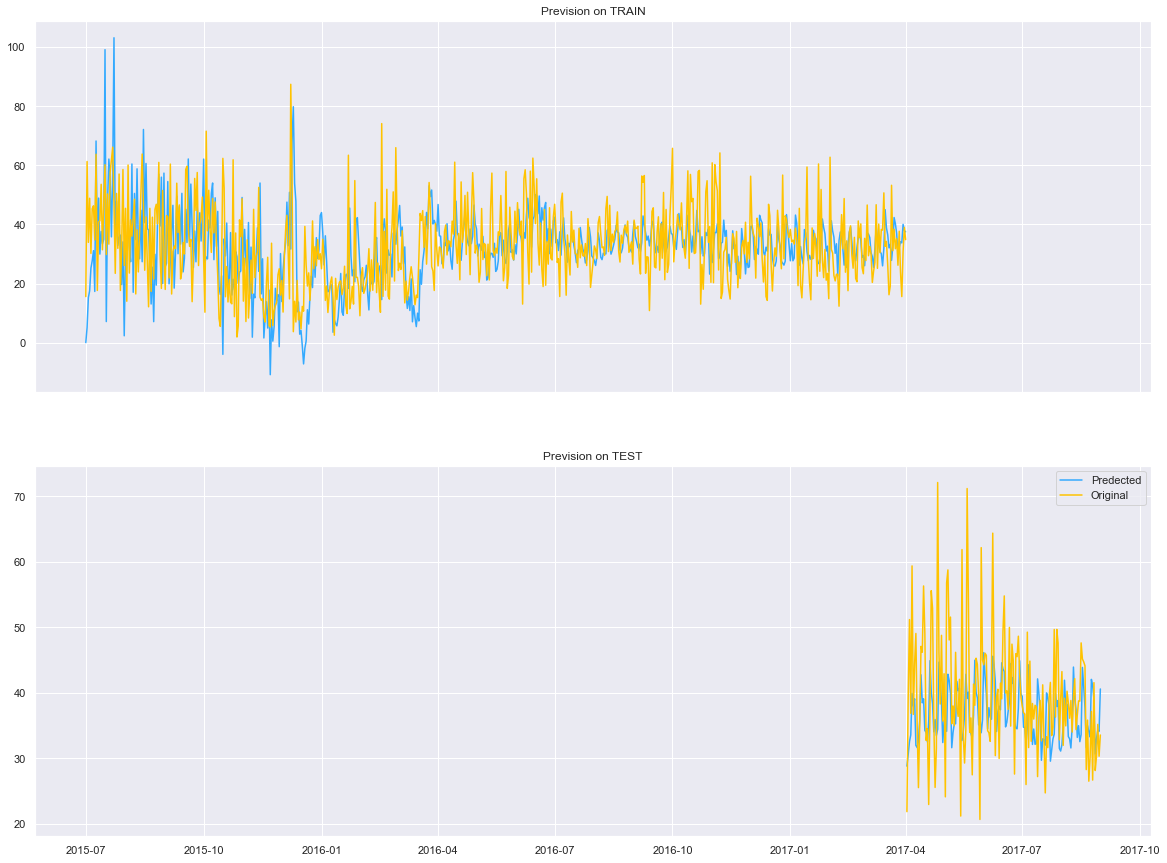

In [67]:
print("ARMONICHE: 6")
start = datetime.now()
modUCM2 = sm.tsa.UnobservedComponents(train, 'llevel',
                                     seasonal = 7,
                                     cycle = True,
                                     freq_seasonal = [{'period': 7, 'harmonics' : 6},
                                                      {'period': 365, 'harmonics' : 6}],
                                     stochastic_seasonal = True,
                                     exog = None)


modUCM2 = modUCM2.fit()
print(modUCM2.summary())
stop = datetime.now()
print("-------------------------------------")
print("execution time :" + str(stop - start))
print("-------------------------------------")
mae_test = make_prediction_test(modUCM2, test, test.index[0], test.index[len(test) - 1], testx)
mae_train = make_prediction_train(modUCM2, train, train.index[0], train.index[len(train) - 1], trainx)
make_prediction_plot(modUCM2, test, test.index[0], test.index[len(test) - 1], testx,
                   train, train.index[0], train.index[len(train) - 1], trainx)
print("Sum of MAE: " + str(mae_train + mae_test))
print("\n\n\n")

In [87]:
def recursive_forecast(y, model, n_steps, step="1D"):

    # get the dates to forecast
    last_date = y.index[-1] + pd.Timedelta(hours=1)
    fcast_range = pd.date_range(last_date, 
                                periods=n_steps, 
                                freq=step)
    fcasted_values = []
    target = y.copy()
    
    for date in fcast_range:
       
        # build target time series using previously forecast value
        new_point = fcasted_values[-1] if len(fcasted_values) > 0 else 0.0   
        target = target.append(pd.Series(index=[date], data=new_point), ignore_index = True)
        
        # build feature vector using previous forecast values
        features = load_data_full(target, seq_len)[0]
        features= features.reshape(-1, 1, features.shape[1])
        
        # forecast
        
        predictions = model.predict(features)
        print("predicted step: " + str(date) + " value: " + str(predictions[-1, 0]))
        fcasted_values.append(predictions[-1, 0])
    return pd.Series(index=fcast_range, data=fcasted_values)




def load_data_full(df, seq_len):
    X = []
    y = []
    for i in range(seq_len, len(df)):
        X.append(df.iloc[i-seq_len : i])
        y.append(df.iloc[i])

    #3 convert to numpy array
    X = np.array(X)
    y = np.array(y)
    
   
    #4 reshape data to input into RNN models
    X = np.reshape(X, (len(X), seq_len, 1))
    return [X, y]

In [70]:
series

,n_canceled,n_total,percentage
datetime,,,
2015-07-01 00:00:00+00:00,19,122,15.57
2015-07-02 00:00:00+00:00,57,93,61.29
2015-07-03 00:00:00+00:00,19,56,33.93
2015-07-04 00:00:00+00:00,43,88,48.86
2015-07-05 00:00:00+00:00,16,53,30.19
...,...,...,...
2017-08-27 00:00:00+00:00,49,174,28.16
2017-08-28 00:00:00+00:00,64,211,30.33
2017-08-29 00:00:00+00:00,44,125,35.20


In [76]:
series.reset_index(inplace = True)

In [78]:
scaler = MinMaxScaler()
series['percentage_norm'] = scaler.fit_transform(series['percentage'].values.reshape(-1, 1))
series = series.set_index(series.datetime)
y = series.resample('D').sum()["percentage_norm"] #fill gap
y[y == 0] = np.nan
y = y.interpolate(method = "linear")
train = y[y.index <= ('2017-04-01')]
test = y[y.index > ('2017-04-01')]
print("Train size: " + str(round((len(train) / len(y) * 100), 2)) + "%")
print("Test size: " + str(round((len(test) / len(y) * 100), 2)) + "%")

Train size: 80.83%
Test size: 19.17%


In [81]:
#create train, test data
seq_len = 30 #choose sequence length
X_train, y_train = load_data_full(train, seq_len)
X_test, y_test = load_data_full(test, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (611, 30, 1)
y_train.shape =  (611,)
X_train.shape =  (122, 30, 1)
y_train.shape =  (122,)


In [92]:
model1 = Sequential()
model1.add(GRU(500, input_shape = (1, seq_len)))
model1.add(Dropout(0.33))
model1.add(BatchNormalization())
model1.add(Dense(500, activation = 'relu'))
model1.add(Dropout(0.33))
model1.add(Dense(500, activation = 'relu'))
model1.add(Dropout(0.33))
model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(loss = 'mae', optimizer = 'adam')
model1.summary()

history = model1.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train.reshape(-1, 1), epochs = 100, batch_size = 150)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 500)               798000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)              

In [93]:
pred1 = recursive_forecast(train[len(train) - 1 - seq_len : ], model1, n_steps = len(test))
metrics.mean_absolute_error(y_pred = scaler.inverse_transform(pred1.values.reshape(-1, 1)), 
                            y_true = scaler.inverse_transform(test.values.reshape(-1,1)))

predicted step: 2017-04-01 01:00:00+00:00 value: 0.43348446
predicted step: 2017-04-02 01:00:00+00:00 value: 0.4453326
predicted step: 2017-04-03 01:00:00+00:00 value: 0.43196905
predicted step: 2017-04-04 01:00:00+00:00 value: 0.47146457
predicted step: 2017-04-05 01:00:00+00:00 value: 0.4465195
predicted step: 2017-04-06 01:00:00+00:00 value: 0.40598002
predicted step: 2017-04-07 01:00:00+00:00 value: 0.41904017
predicted step: 2017-04-08 01:00:00+00:00 value: 0.46906036
predicted step: 2017-04-09 01:00:00+00:00 value: 0.4725156
predicted step: 2017-04-10 01:00:00+00:00 value: 0.4649799
predicted step: 2017-04-11 01:00:00+00:00 value: 0.4562288
predicted step: 2017-04-12 01:00:00+00:00 value: 0.46232122
predicted step: 2017-04-13 01:00:00+00:00 value: 0.41352168
predicted step: 2017-04-14 01:00:00+00:00 value: 0.45247942
predicted step: 2017-04-15 01:00:00+00:00 value: 0.46703985
predicted step: 2017-04-16 01:00:00+00:00 value: 0.45363456
predicted step: 2017-04-17 01:00:00+00:00 val

8.570815076855453

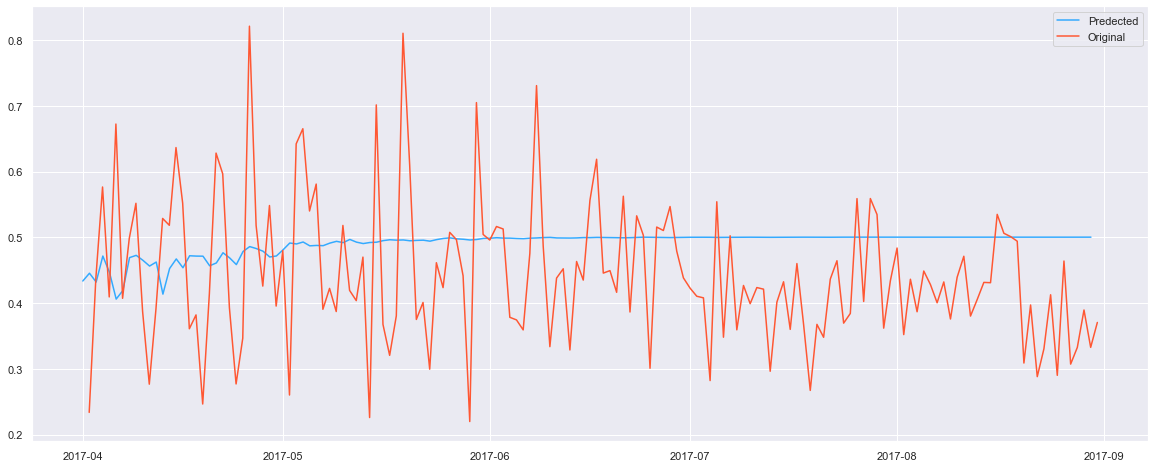

In [94]:
plt.rcParams.update({'figure.figsize':(20, 8)})
plt.plot(pred1, color = "#33AAFF", label = "Predected")
plt.plot(test, color = "#FF5733", label = "Original")
plt.legend()